https://machinelearningmastery.com/how-to-develop-convolutional-neural-networks-for-multi-step-time-series-forecasting/

https://unit8.com/resources/temporal-convolutional-networks-and-forecasting/

https://unit8.com/resources/darts-time-series-made-easy-in-python/

https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tcn_model.html


# 1. Establecimiento del ambiente de desarrollo y ejecución.

**COLAB**:
A comienzos de marzo de 2025, la versión de Numpy instalada por defecto en Colab tuvo una actualización bastante importante, al pasar a la versión 2.
Varios packages de Python se ven afectados por este cambio, mientras se actualizan ellos también a las nuevas estructuras de las evoluciones de sus dependencias.
Particularmente, la librería **Darts** de tratamiento de problemas de Forecasting de datos temporales no funciona por el momento con esta nueva versión de numpy, por lo que se hace necesario desinstalarla y forzar la instalación de la última versión de Numpy 1.

In [6]:
#!pip uninstall numpy -y

In [2]:
import numpy as np
print(np.__version__)

2.0.2


In [7]:
#!pip install --force-reinstall numpy==1.26.4

Para que los campos tomen efecto, se necesita reinicializar la sesión de colab (Menú de Runtime).

In [4]:
import numpy as np
print(np.__version__)

1.26.4


Ahora si se puede instalar la librería **Darts**.

In [2]:
#!pip install darts

^C
Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/56.0 kB ? eta -:--:--
     ------- -------------------------------- 10.2/56.0 kB ? eta -:--:--
     ------------- ------------------------ 20.5/56.0 kB 165.2 kB/s eta 0:00:01
     -------------------- ----------------- 30.7/56.0 kB 217.9 kB/s eta 0:00:01
     -------------------------------------- 56.0/56.0 kB 293.4 kB/s eta 0:00:00
  Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl.metadata (15 kB)
   ---------------------------------------- 0.0/981.0 kB ? eta -:--:--
   --------------- ------------------------ 368.6/981.0 kB 7.8 MB/s eta 0:00:01
   --------------------------------------  972.8/981.0 kB 12.3 MB/s eta 0:00:01
   --------------------------------------- 981.0/981.0 kB 10.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/320.1 kB ? eta -:--:--
   ---------------------------------------- 320.1/320.1 kB ? eta 0:00:00
Us

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
u8darts 0.32.0 requires scikit-learn<1.6.0,>=1.0.1, but you have scikit-learn 1.6.1 which is incompatible.


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TCNModel, RNNModel
from darts.metrics import mape, mse
from darts.utils.likelihood_models import GaussianLikelihood
from torchmetrics import MeanAbsolutePercentageError
from pytorch_lightning.callbacks import Callback
import zipfile
import requests
import io
import os


In [8]:
if torch.cuda.is_available():
    print("Utilizamos la primera GPU disponible")
    DEVICE=device = torch.device('cuda:0')
    os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
else:
    print("No hay GPU, toca correr todo en CPU")
    DEVICE=device = torch.device('cpu')

DEVICE

Utilizamos la primera GPU disponible


device(type='cuda', index=0)

# 2. Preparación del Dataset

Descargamos el dataset que utilizaremos como ejemplo.

In [9]:
url = "https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("data")

Cargamos el dataset en un `DataFrame`.

In [10]:
file_path = "data/household_power_consumption.txt"
df = pd.read_csv(
    file_path,
    sep=';',
    na_values='?',
    low_memory=False
)
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


Combinamos la fecha y el tiempo en un solo campo, y lo establecemos como índice.

In [11]:
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
df.drop(columns=['Date', 'Time'], inplace=True)
df.set_index('datetime', inplace=True)

df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [12]:
df.shape

(2075259, 7)

In [13]:
df.iloc[0, :]

Global_active_power        4.216
Global_reactive_power      0.418
Voltage                  234.840
Global_intensity          18.400
Sub_metering_1             0.000
Sub_metering_2             1.000
Sub_metering_3            17.000
Name: 2006-12-16 17:24:00, dtype: float64

In [14]:
df.iloc[-1, :]

Global_active_power        0.932
Global_reactive_power      0.000
Voltage                  239.550
Global_intensity           3.800
Sub_metering_1             0.000
Sub_metering_2             0.000
Sub_metering_3             0.000
Name: 2010-11-26 21:02:00, dtype: float64

Vemos que tenemos mas de dos millones de registros, empezando el 16 de diciembre de 2006 y llegando al 26 de noviembre de 2010, con una captura de datos cada minuto. Es decir que en un día hay 24*60=1440 registros.

Dado el elevado número de registros, hay que tener cuidado si se quieren crear plots sobre el dataset completo.

In [15]:
df.describe(include='all')

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


Verificamos si hay valores faltantes en el dataset.

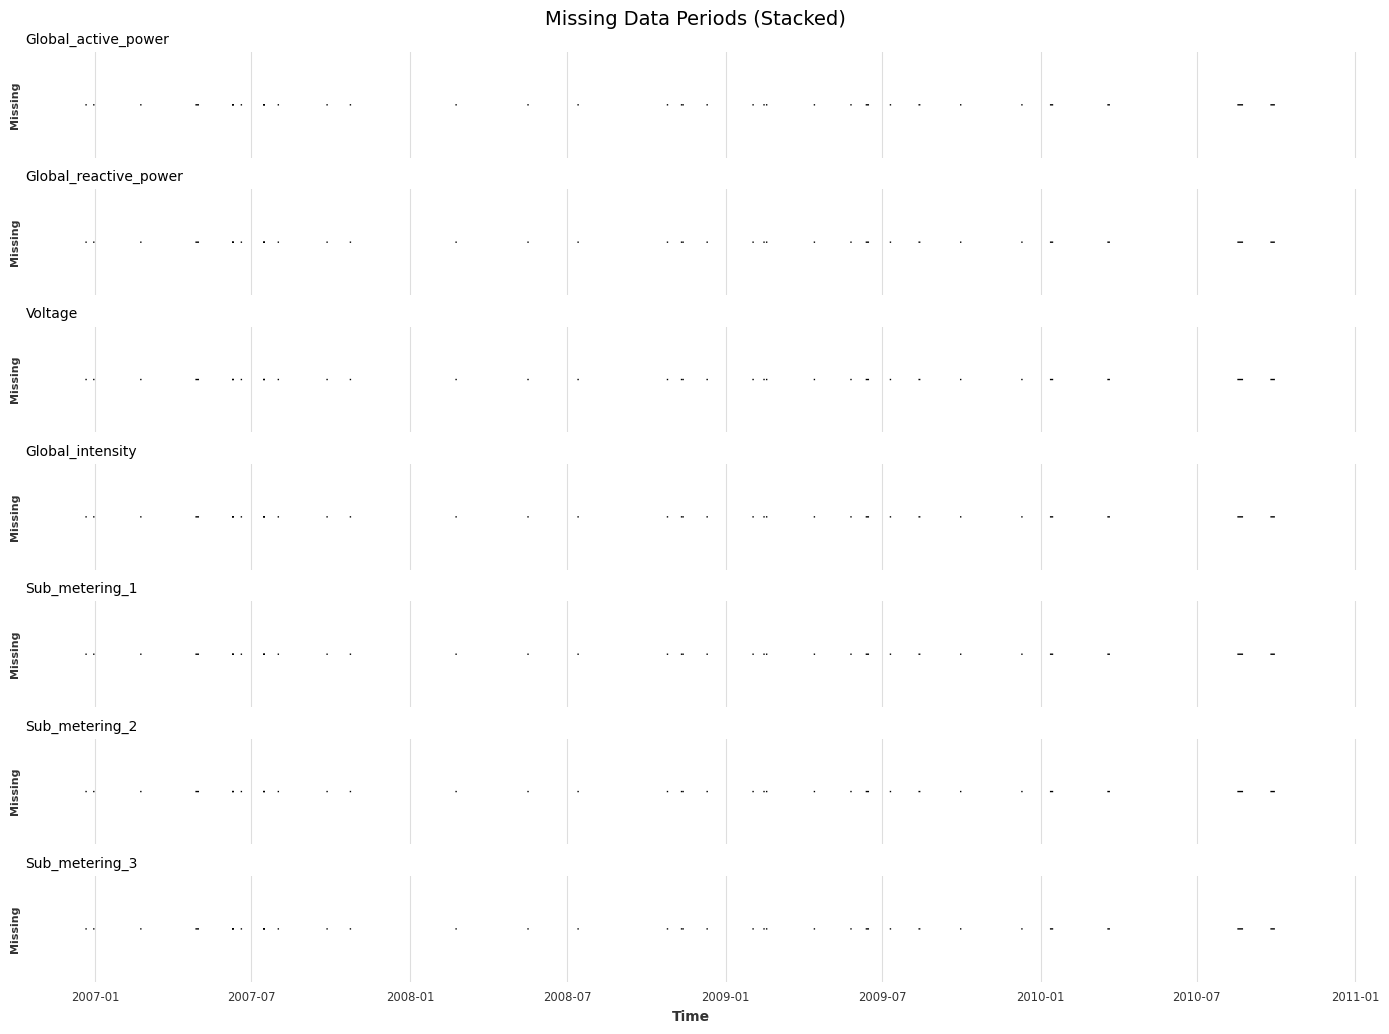

In [16]:
def plot_missing_periods_stacked(df, title='Missing Data Periods (Stacked)'):
    """
    Plots missing data periods for each column, stacked vertically with shared x-axis.
    Only missing timestamps are shown.
    """
    num_cols = len(df.columns)
    fig, axes = plt.subplots(nrows=num_cols, figsize=(14, 1.5 * num_cols), sharex=True, sharey=False)

    for i, col in enumerate(df.columns):
        ax = axes[i] if num_cols > 1 else axes
        missing = df[col].isna()

        # Create a time series with 1s where values are missing
        missing_series = pd.Series(np.where(missing, 1, np.nan), index=df.index)
        ax.plot(missing_series, linewidth=1)
        ax.set_title(col, loc='left', fontsize=10)
        ax.set_yticks([])  # Hide y-axis ticks
        ax.set_ylabel('Missing', fontsize=8)

    plt.xlabel('Time')
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.94, hspace=0.3)
    plt.show()

plot_missing_periods_stacked(df)

In [17]:
df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [18]:
df[df.isna().any(axis=1)].head(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-21 11:23:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-21 11:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-30 10:08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-30 10:09:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-14 18:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-28 17:13:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-02-22 22:58:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-02-22 22:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-03-25 17:52:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Vemos que los registros con valores faltantes los presentan al parecer en todos los campos. Además, algunos de los registros con problemas son seguidos. Esto puede deberse, por ejemplo, a una desconexión temporal de los sensores utilizados para capturar los datos.

Después de consultar con expertos en el contexto negocio, estimamos que podemos remplazarlos por los valores correspondientes a los registros del mismo día de la semana anterior a la misma hora.

In [19]:
def fill_missing_with_previous_day(df):
    df_filled = df.copy()
    for col in df.columns:
        na_mask = df_filled[col].isna()
        df_filled.loc[na_mask, col] = df_filled[col].shift(24*60*7)[na_mask]
    return df_filled

In [20]:
df_limpio = fill_missing_with_previous_day(df)
df_limpio.iloc[98254:98256, :]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2007-02-22 22:58:00,1.624,0.0,243.79,6.6,0.0,0.0,18.0
2007-02-22 22:59:00,1.630,0.0,244.27,6.6,0.0,0.0,18.0


In [21]:
df = df_limpio
df.isna().sum()

Global_active_power      3
Global_reactive_power    3
Voltage                  3
Global_intensity         3
Sub_metering_1           3
Sub_metering_2           3
Sub_metering_3           3
dtype: int64

In [22]:
df[df.isna().any(axis=1)].head(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-21 11:23:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-21 11:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-07-22 18:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Seguimos teniendo 3 registros vacíos:
- Los dos primeros coinciden con la primera semana de las series, por lo que no tienen un datos de la semana anterior sobre la cual basarse. Podemos tomar la decisión de saltarnos los primeros días.
- El tercero se explica por que habían dos registros a la misma hora con missing values en semanas consecutivas, lo podemos remplazar corriendo una vez más el proceso.

In [23]:
df = df[df.index >= pd.Timestamp("2006-12-22")]
df = fill_missing_with_previous_day(df)
df[df.isna().any(axis=1)].head(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,


In [24]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-22 00:00:00,0.206,0.000,245.70,0.8,0.0,0.0,0.0
2006-12-22 00:01:00,0.206,0.000,246.18,0.8,0.0,0.0,0.0
2006-12-22 00:02:00,0.328,0.130,245.61,1.4,0.0,0.0,0.0
2006-12-22 00:03:00,0.314,0.128,244.63,1.4,0.0,0.0,0.0
2006-12-22 00:04:00,0.310,0.128,244.51,1.4,0.0,0.0,0.0


Ahora los datos comienzan el 22 de diciembre de 2006.

Establecemos un granularidad horaria, sumando los valores agregados.

In [25]:
df = df.resample('h').sum()

In [26]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-22 00:00:00,16.016,4.748,14740.69,68.6,0.0,0.0,0.0
2006-12-22 01:00:00,16.320,5.562,14667.23,70.4,0.0,31.0,0.0
2006-12-22 02:00:00,16.058,4.756,14810.27,68.6,0.0,0.0,0.0
2006-12-22 03:00:00,16.432,5.612,14747.57,70.4,0.0,31.0,0.0
2006-12-22 04:00:00,15.856,4.336,14721.57,68.2,0.0,0.0,0.0


# 3. Creamos los TimeSeries en Darts

Creamos la instacia de `TimeSeries` multivariada.

In [27]:
series = TimeSeries.from_dataframe(df)

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_timeseries_with_months(ts, figsize=(14, 4), title="Time Series Plot", date_format='%b %Y'):
    """
    Plots a Darts TimeSeries object with months labeled on the x-axis and custom dimensions.
    """
    plt.figure(figsize=figsize)
    ts.plot()

    ax = plt.gca()
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")

    # Format x-axis with months
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter(date_format))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

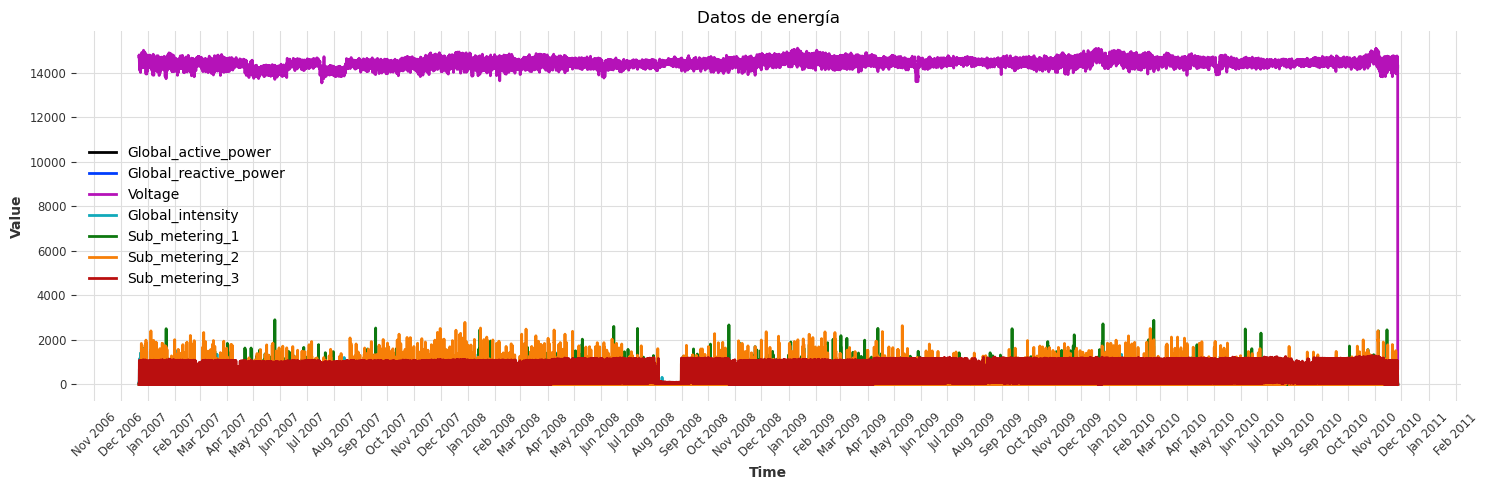

In [29]:
plot_timeseries_with_months(series,(15,5), "Datos de energía")

Podemos ver que hay un hueco en agosto de 2008, en la mayoría de las variables, y que hay una caida importante en voltage en los últimos días. Veamos como nos va si ploteamos noviembre de 2010.

In [30]:
series1, series2 = series.split_before(pd.Timestamp('2010-11-01'))

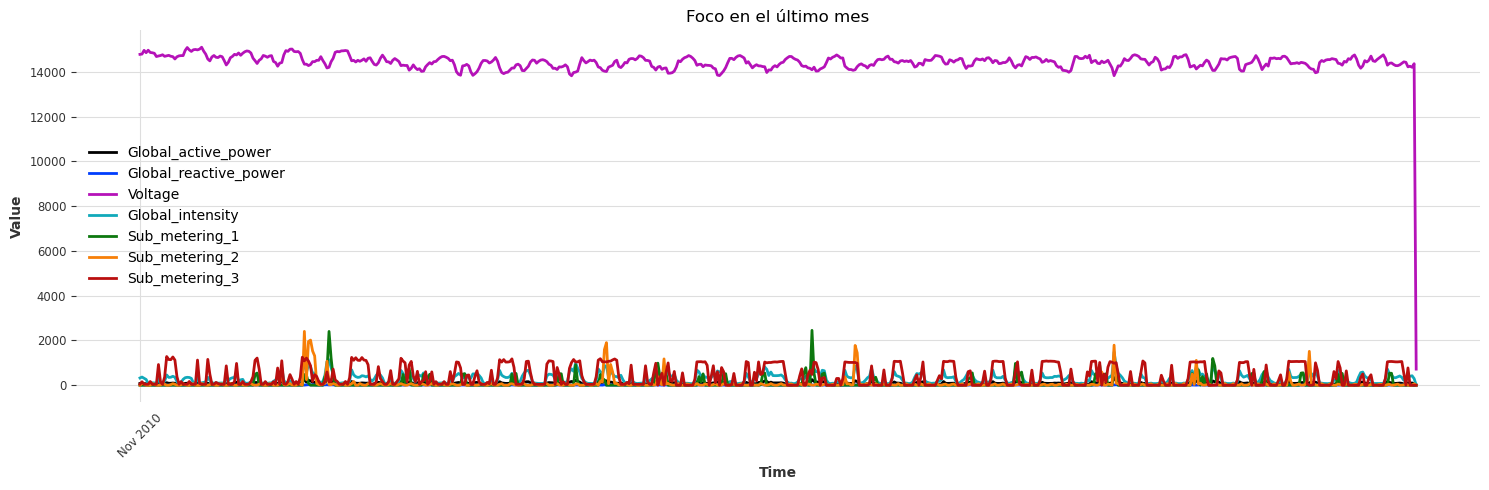

In [31]:
plot_timeseries_with_months(series2,(15,5), "Foco en el último mes")

Notamos que la caída se presenta solo en el último día, esta se puede explicar fácilmente gracias a que los datos originales no consideraban el día completo. Vamos a eliminar el registro correspondiente.

In [32]:
series1, series2 = series.split_before(pd.Timestamp('2010-11-26'))

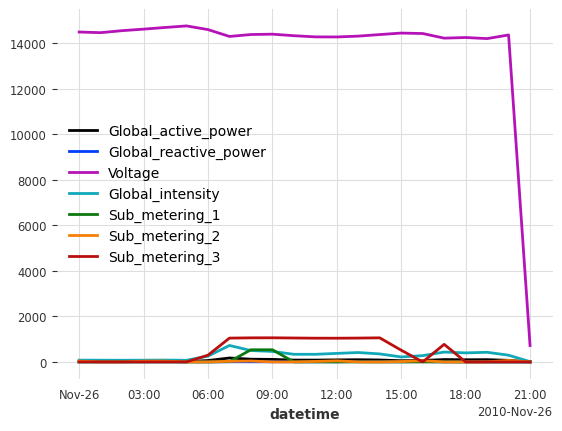

In [33]:
series2.plot();

In [34]:
series = series1

Veamos agosto de 2008.

In [35]:
series1, series2 = series.split_before(pd.Timestamp('2008-07-15'))
series1, series2 = series2.split_before(pd.Timestamp('2008-09-15'))
series1 = series1[['Global_active_power', 'Global_reactive_power', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]

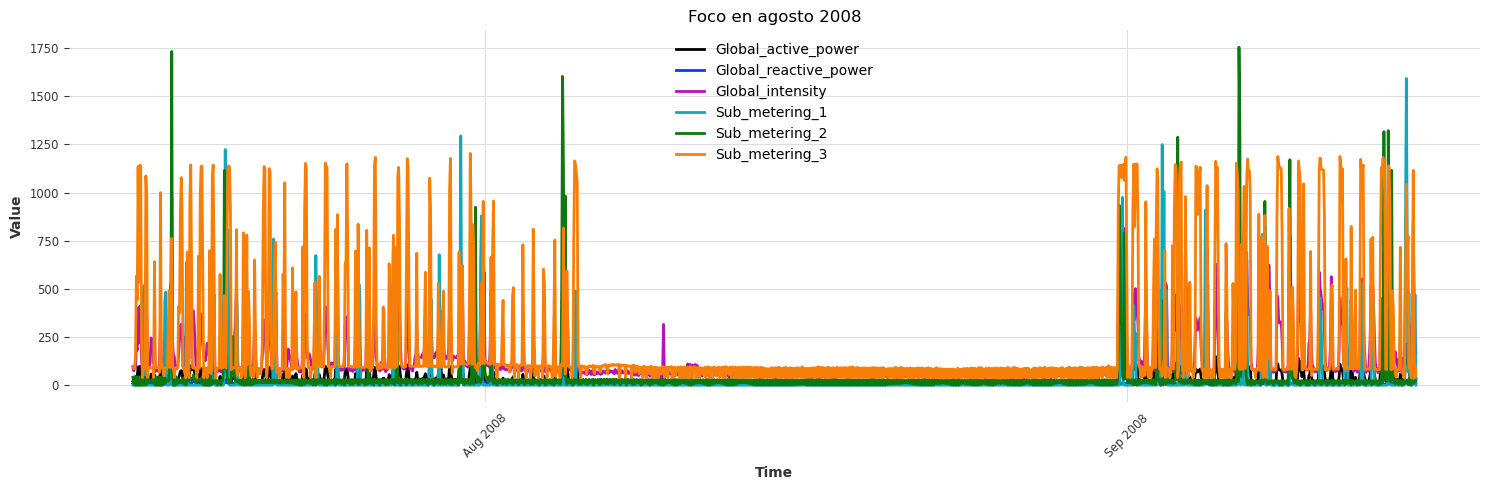

In [36]:
plot_timeseries_with_months(series1,(15,5), "Foco en agosto 2008")

Vemos que en agosto si hay valores (aunque muy pequeños), y encontramos varibilidad, por lo que decidimos no tomar ninguna acción.


# 3. Entrenamiento del modelo.

Escalamos los datos y preparamos los datasets de entrenamiento y validación, un poco mas de un año de validación.

In [37]:
scaler = Scaler()
series_scaled = scaler.fit_transform(series)

In [38]:
train, val = series_scaled.split_after(pd.Timestamp("2009-10-01"))
val, test = val.split_after(pd.Timestamp("2010-03-01"))

Seleccionamos las variables independientes (en Darts, se les llama `past_covariates`) y las variables que queremos predecir. Vamos a pronosticar
*Global_active_power* a partir de todas las demás variables (Podríamos tener varias variables a pronosticar al tiempo).

**Importante**:
- Las variables objetivo no deben estar incluidas en las covariables pasadas
- Las covariables pasadas deben pasarase al método `fit()` durante el entrenamiento, tienen que cubrir el periodo de tiempo de la variable objetivo.
- Las covariables pasadas deben pasarase al método `predict()` durante la inferencia, tienen que cubrir el periodo de tiempo correspondiente al número de valores futuros que se desea pronosticar.

In [39]:
target_features = ['Global_active_power']
past_covs = set(train.components.to_list()).difference(set(target_features))
past_covs = list(past_covs) # todas las variables disponibles menos las del target
past_covs

['Voltage',
 'Global_intensity',
 'Sub_metering_2',
 'Sub_metering_1',
 'Global_reactive_power',
 'Sub_metering_3']

In [40]:
target_features

['Global_active_power']

Vamos a ensayar inicialmente con un pequeño número de épocas (10).
Luego lo podremos cambiar usando `model.n_epochs = 50`, por ejemplo.

La clase del modelo `TCNModel` recibe como hiperparámetros de construcción:
- `input_chunk_length` (int): tamaño de la ventana de entrada histórica que el modelo utiliza para realizar predicciones. Por ejemplo, si se establece en 30, el modelo tomará los últimos 30 pasos temporales como entrada para generar pronósticos. Este parámetro es clave para determinar la cantidad de datos históricos que el modelo considera relevantes para predecir valores futuros.
- `output_chunk_length` (int):  longitud del horizonte de predicción que el modelo genera en cada paso. Esto significa que determina cuántos puntos de datos futuros el modelo pronosticará en una sola ejecución. Por ejemplo, si se establece en 12, el modelo producirá una secuencia de 12 valores futuros en cada predicción.
Este parámetro es crucial para ajustar el modelo a las necesidades específicas de la tarea de pronóstico, ya que afecta directamente el alcance de las predicciones y la forma en que el modelo se entrena para manejar múltiples pasos futuros simultáneamente
- `output_chunk_shift` (int, opcional): número de pasos para desplazar el inicio del segmento de salida hacia el futuro (en relación con el final del segmento de entrada). Esto creará un intervalo entre la entrada y la salida. Si el modelo admite future_covariates, los valores futuros se extraerán del segmento de salida desplazado. Las predicciones comenzarán output_chunk_shift pasos después del final de la serie objetivo. Si se configura output_chunk_shift, el modelo no podrá generar predicciones autorregresivas (n > output_chunk_length).
- `kernel_size (int)`: Tamaño del filtro convolucional (3, por defecto).
- `num_filters (int)`: Número de filtros convolucionales (3, por defecto).
- `weight_norm (bool)`: Boolean value indicating whether to use weight normalization.
- `dilation_base (int)`: Base exponencial para la determinación de la dilación (3, por defecto).
- `dropout (float)`: Valor de dropout de regularización para cada capa convolucional.
- `batch_size (int)`: Tamaño del batch de entrenamiento (32, por defecto).
- `n_epochs (int)`: número de épocas de entrenamiento (100, por defecto).
- `random_state`: semilla aleatoria
- `loss_fn`: Función de pérdida a utilizar de Pytorch para el entrenamiento (torch.nn.MSELoss(), por defecto).
- `optimizer_cls`: Optimizador de PyTorch a utilizar (torch.optim.Adam, por defecto).
- `optimizer_kwargs`: Argumentos keyword a utilizar por el optimizador de PyTorch (e.g., {'lr': 1e-3}).
- `lr_scheduler_cls`: Learning rate scheduler de PyTorch a utilizar.
- `lr_scheduler_kwargs`: Argumentos keyword a utilizar por el learning rate scheduler.
- `likelihood`: modelos a utilizar para estimar incertifumbre y generar salidas probabilísticas. Se puede entonces generar intervalos de confianza de los forecasts, al establecer un muestreo, por ejemplo: `pred = model.predict(n=12, num_samples=500)`.
- `torch_metrics`: una colección de métricas a utilizar para evaluar. Las métricas disponibles están en https://torchmetrics.readthedocs.io/en/latest/.
- `pl_trainer_kwargs`: internamente, Darts utiliza la librería **Pytorch Lightning**, con este argumento, se le puede pasar parámetros adicionales al modelo subyacente. Se utiliza por ejemplo para agregar instancias de modelos **CallBack** para monitorear la ejecución del entrenamiento o de la predicción.
- `**kwargs`: Argumentos keyword adicionales que puede necesitar la librería de pytorch de base.


In [44]:
model_tcn = TCNModel(
    input_chunk_length=48,
    output_chunk_length=24,
    kernel_size=3,
    num_filters=5,
    dilation_base=2,
    dropout=0.1,
    weight_norm=True,
    batch_size=64, #optimizer
    n_epochs=5, #optimizer
    optimizer_kwargs={"lr": 1e-3}, #optimizer
    random_state=42,
    likelihood=GaussianLikelihood(),
    torch_metrics=MeanAbsolutePercentageError(), 
)

Para entrenar un modelo **TCN**, utilizamos el método `fit`, que recibe una o varias series de tiempo.
- **series** (Union[TimeSeries, Sequence[TimeSeries]]): una serie o una secuencia de series que servirán como variable objetivo a pronósticar
- **past_covariates** (Union[TimeSeries, Sequence[TimeSeries], None]): opcional, una serie o secuencia de series con otras covariables pasadas que se quieran considerar como información predictiva
- **val_series** (Union[TimeSeries, Sequence[TimeSeries]]): una serie o una secuencia de series que servirán como variable objetivo a validar
- **val_past_covariates** (Union[TimeSeries, Sequence[TimeSeries], None]): opcional, una serie o secuencia de series con otras covariables pasadas que se quieran considerar como información predictiva del set de validación.

In [45]:
model_tcn.fit(series=train[target_features], 
          past_covariates=train[past_covs], 
          val_series=val[target_features],  
          val_past_covariates=val[past_covs],
          verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 711    | train
------------

Sanity Checking: |                                                                               | 0/? [00:00<…

C:\ProgramData\anaconda3\envs\cuda\Lib\site-packages\pytorch_lightning\core\module.py:512: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

C:\ProgramData\anaconda3\envs\cuda\Lib\site-packages\pytorch_lightning\core\module.py:512: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.


TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=5, num_layers=None, dilation_base=2, weight_norm=True, dropout=0.1, input_chunk_length=48, output_chunk_length=24, batch_size=64, n_epochs=5, optimizer_kwargs={'lr': 0.001}, random_state=42, likelihood=GaussianLikelihood(prior_mu=None, prior_sigma=None, prior_strength=1.0, beta_nll=0.0), torch_metrics=MeanAbsolutePercentageError())

Para obtener predicciones, se utiliza el método `predict()`, que recibe los siguientes argumentos:
- `n (int)`: el número de pasos de tiempo de la secuencia a predecir.
- `series (Union[TimeSeries, Sequence[TimeSeries], None])`, opcional: La(s) serie(s) representando la historia de la(s) variable(s) a predecir.
- `past_covariates (Union[TimeSeries, Sequence[TimeSeries], None])`, opcional: Las observaciones de las covariables pasadas, necesarias como inputs del modelo. Deben tener la misma estructura que las covariables pasadas utilizadas en el entrenamiento.
- `future_covariates (Union[TimeSeries, Sequence[TimeSeries], None])`, opcional:  Las covariables futuras conocidas necesarias como entradas al modelo. Deben tener la misma estructura que las covariables futuras utilizadas en el entrenamiento.
- `num_samples (int)`: Número de veces que una muestra se extraerá del modelo probabilístico, permite crear intervalos de confianza de los pronósticos. Debe ser 1 para modelos determinísticos.

Vamos a ilustrar la funcionalidad de creación de intervalos de confianza, estableciendo un número de muestras a utilizar con `num_samples` para generar varias trayectorias. Cada una de ellas va a quedar almacenada en el objeto `TimeSeries` que retorna el método `predict()` como dimensiones paralelas.

In [47]:
forecast = model_tcn.predict(len(val), past_covariates=series_scaled[past_covs], verbose=True, show_warnings=False, num_samples=30)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

Podemos acceder directamente a todas las trayectorias:

In [53]:
trajectories = forecast.all_values()
trajectories.shape

(3624, 1, 30)

In [56]:
len(val)

3624

Vemos que los ejes están organizados como (pasos de tiempo, feature objetivo, número de muestras) 

In [58]:
trajectories_transposed = np.transpose(trajectories, (2, 0, 1))
trajectories_transposed.shape

(30, 3624, 1)

Tenemos un tensor que crea 30 (num_samples) secuencias de 3624 pasos de tiempo (el largo del dataset de validación), de 1 única variables objetivo.

<Axes: xlabel='datetime'>

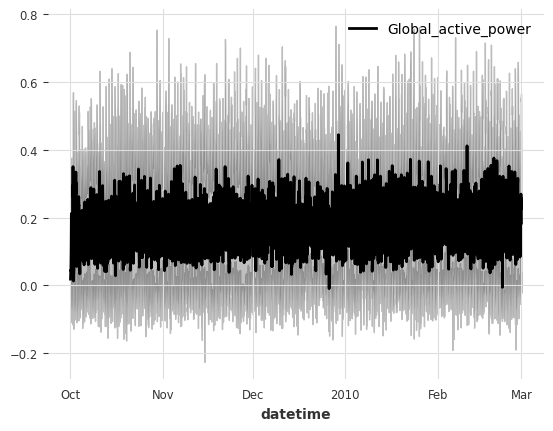

In [61]:
forecast.plot()  # Shows median + 95% confidence interval

Vamos a focalizarnos en el comienzo de la serie para que sea más fácil de visualizar.

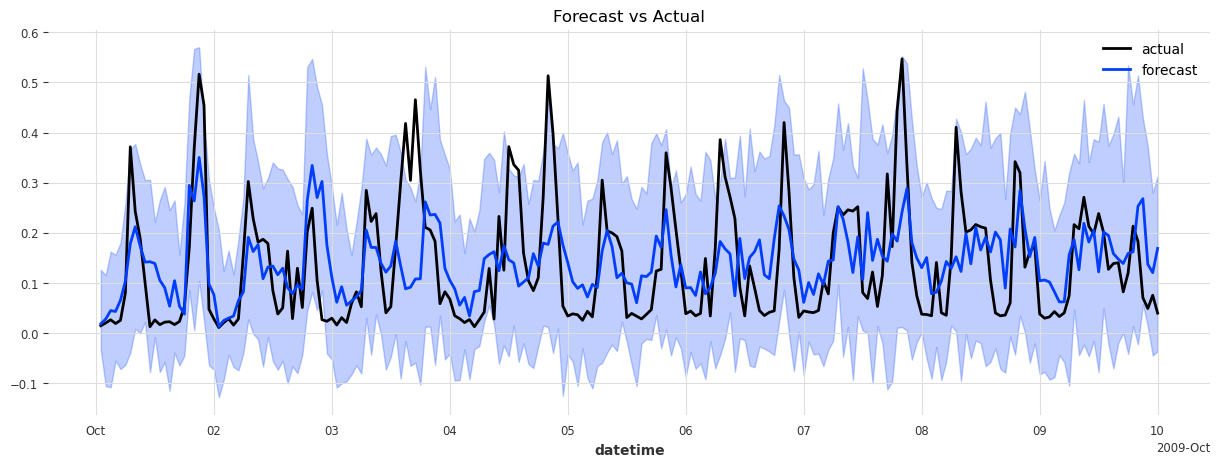

In [62]:
start = pd.Timestamp("2009-10-01")
end = pd.Timestamp("2009-10-10")

plt.figure(figsize=(15, 5))
val[target_features].slice(start, end).plot(label='actual')
forecast[target_features].slice(start, end).plot(label='forecast')
plt.legend()
plt.title("Forecast vs Actual")
plt.show()

Podemos plotear también las diferentes trayectorias

In [60]:
first_trajectory = trajectories_transposed[0]  # primera muestra
first_trajectory = first_trajectory.squeeze()
first_trajectory.shape

(3624,)

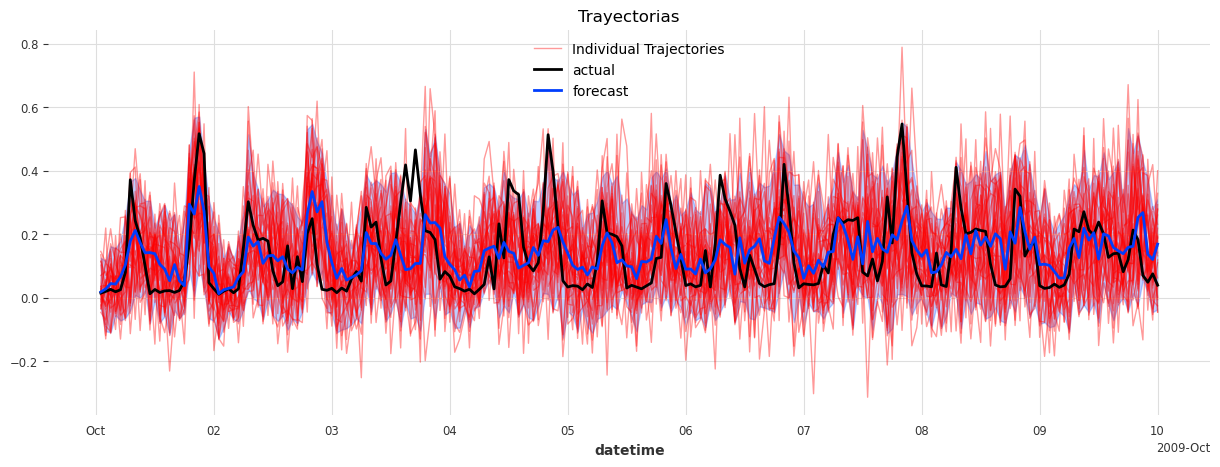

In [78]:
start = pd.Timestamp("2009-10-01")
end = pd.Timestamp("2009-10-10")

plt.figure(figsize=(15, 5))

trajectories = forecast[target_features].slice(start, end).all_values()
trajectories_transposed = np.transpose(trajectories, (2, 0, 1))
for i in range(len(trajectories_transposed)):
    trajectory = trajectories_transposed[i]
    trajectory = trajectory.squeeze()

    plt.plot(
        forecast[target_features].slice(start, end).time_index,
        trajectory,
        color='red',
        alpha=0.4,
        linewidth=1,
        label='Individual Trajectories' if i == 0 else ""
    )

val[target_features].slice(start, end).plot(label='actual')
forecast[target_features].slice(start, end).plot(label='forecast')

plt.title("Trayectorias")
plt.show()

Para poder haer un seguimiento de las métricas de ajuste del modelo durante el proceso de entrenamiento, utilizaremos instancias de la clase `Callback` de **PyTorch Lightning**.
Estos objetos permiten inyectar lógica no esencial en el ciclo de entrenamiento sin tener que modificar el código pre establecido.
Permiten crear acciones a ejecutarse en puntos específicos del proceso de entrenamiento, validación, testing, y otros eventos del ciclo de vida de os modelos.
Se utilizan por ejemplo para capturar lógica de loggins, de early stopping, de métricas de performance, entre otras.
Los métodos más utilizados son: 
- `on_train_start()`: Llamado al comienzo del entrenamiento.
- `on_train_end()`: Llamado al final del entrenamiento.
- `on_epoch_start()`: Llamado al comienzo de una época.
- `on_epoch_end()`: Llamado al final de una época.
- `on_batch_start()`: Llamado al comienzo de un batch.
- `on_batch_end()`: Llamado al final de un batch.
- `on_validation_start()`: Llamado al comienzo del ciclo de validación.
- `on_validation_end()`: Llamado al final del ciclo de validación.
- `on_test_start()`: Llamado al comienzo del ciclo de test.
- `on_test_end()`: Llamado al final del ciclo de test.

Creamos entonces un `Callback` que se encargará de guardar las métricas del MAPE sobre el training set y sobre el validation set a lo largo de las épocas de entrenamiento.

In [86]:
class MAPELogger(Callback):
    def __init__(self):
        self.train_mape = []
        self.val_mape = []
    def on_train_epoch_end(self, trainer, pl_module):
        # Retrieve training MAPE from Lightning's logged metrics (if available)
        mape = trainer.callback_metrics.get("train_MeanAbsolutePercentageError")
        if mape is not None:
            self.train_mape.append(float(mape))
            print(f"Epoch {trainer.current_epoch}: Train MAPE = {self.train_mape[-1]:.4f}")
    def on_validation_epoch_end(self, trainer, pl_module):
        # Retrieve validation MAPE from logged metrics
        mape = trainer.callback_metrics.get("val_MeanAbsolutePercentageError")
        if mape is not None:
            self.val_mape.append(float(mape))
            print(f"Epoch {trainer.current_epoch}: Val MAPE = {self.val_mape[-1]:.4f}")

# Instantiate the callback
mape_logger = MAPELogger()

Para poder utilizarlo, lo asociamos al modelo a través del argumento `pl_trainer_kwargs`, que recibe un diccionario con parámetros adicionales a transferir a Pytorch lightning. Particularmente lo seteamos como parte de la lista de valores asociados a la llave `callbacks`.

In [87]:
model_tcn = TCNModel(
    input_chunk_length=48,
    output_chunk_length=24,
    kernel_size=3,
    num_filters=5,
    dilation_base=2,
    dropout=0.1,
    weight_norm=True,
    batch_size=64, #optimizer
    n_epochs=5, #optimizer
    optimizer_kwargs={"lr": 1e-3}, #optimizer
    random_state=42,
    likelihood=GaussianLikelihood(),
    torch_metrics=MeanAbsolutePercentageError(), 
    pl_trainer_kwargs={"callbacks": [mape_logger]}  # Attach our MAPELogger callback&#8203;:contentReference[oaicite:10]{index=10}&#8203;:contentReference[oaicite:11]{index=11}
)

Ahora podemos relanzar el entrenamiento.

In [88]:
model_tcn.fit(series=train[target_features], 
          past_covariates=train[past_covs], 
          val_series=val[target_features],  
          val_past_covariates=val[past_covs],
          verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 711    | train
-------------------------------------------------------------
711       Trainable params
0         Non-trainable params
711       Total params
0.003     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\ProgramData\anaconda3\envs\cuda\Lib\site-packages\pytorch_lightning\core\module.py:512: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

C:\ProgramData\anaconda3\envs\cuda\Lib\site-packages\pytorch_lightning\core\module.py:512: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Validation: |                                                                                    | 0/? [00:00<…

Epoch 1: Val MAPE = 1.5588
Epoch 1: Train MAPE = 13.4812


Validation: |                                                                                    | 0/? [00:00<…

Epoch 2: Val MAPE = 1.4484
Epoch 2: Train MAPE = 6.2578


Validation: |                                                                                    | 0/? [00:00<…

Epoch 3: Val MAPE = 1.5266
Epoch 3: Train MAPE = 5.5169


Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: Val MAPE = 1.5218
Epoch 4: Train MAPE = 5.1072


TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=5, num_layers=None, dilation_base=2, weight_norm=True, dropout=0.1, input_chunk_length=48, output_chunk_length=24, batch_size=64, n_epochs=5, optimizer_kwargs={'lr': 0.001}, random_state=42, likelihood=GaussianLikelihood(prior_mu=None, prior_sigma=None, prior_strength=1.0, beta_nll=0.0), torch_metrics=MeanAbsolutePercentageError(), pl_trainer_kwargs={'callbacks': [<__main__.MAPELogger object at 0x0000014EB6D978F0>]})

Al final del entrenamiento, podemos acceder a las variables del objeto callback.

In [89]:
mape_logger.val_mape

[1.5588284730911255, 1.448376178741455, 1.5265623331069946, 1.5217862129211426]

Podemos ahora plotear el avance de las métricas durante el entrenamiento.

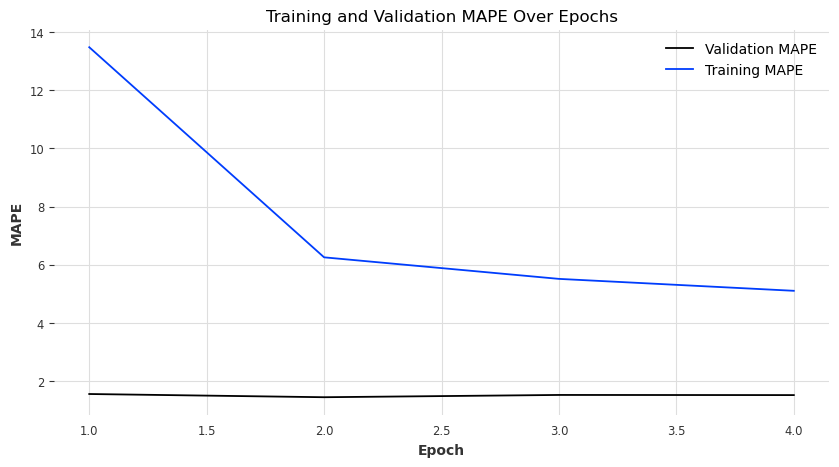

In [90]:
epochs = list(range(1, len(mape_logger.val_mape) + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, mape_logger.val_mape, label="Validation MAPE")
plt.plot(epochs, mape_logger.train_mape, label="Training MAPE")

plt.xlabel("Epoch")
plt.ylabel("MAPE")
plt.title("Training and Validation MAPE Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [92]:
forecast = model_tcn.predict(len(val), past_covariates=series_scaled[past_covs], verbose=True, show_warnings=False, num_samples=30)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

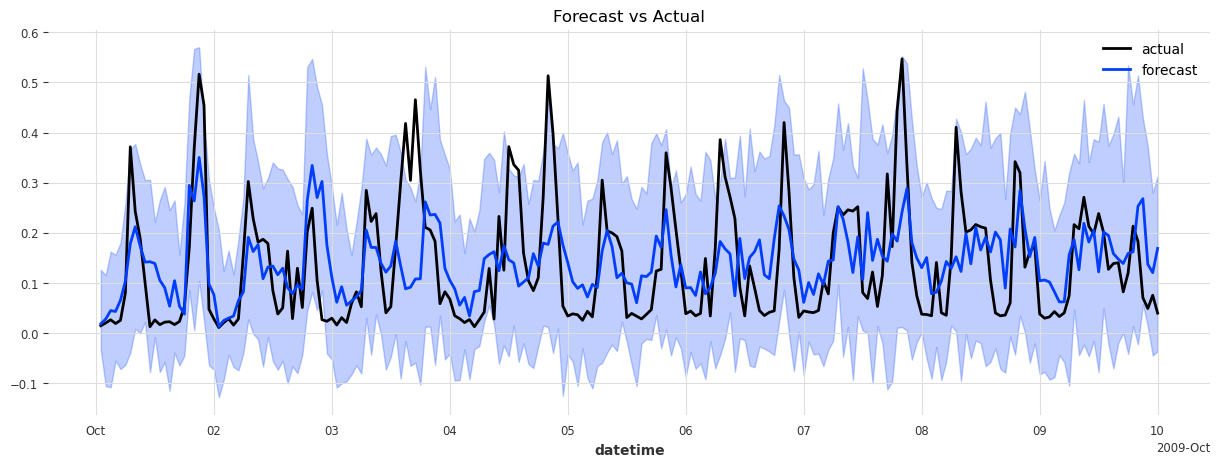

In [93]:
start = pd.Timestamp("2009-10-01")
end = pd.Timestamp("2009-10-10")

plt.figure(figsize=(15, 5))
val[target_features].slice(start, end).plot(label='actual')
forecast[target_features].slice(start, end).plot(label='forecast')
plt.legend()
plt.title("Forecast vs Actual")
plt.show()

In [94]:
score = mape(val[target_features], forecast)
print(f"TCN MAPE: {score:.2f}")

TCN MAPE: 112.78


Vamos ahora a crear una función que incluya toda la lógica para poder entrenar y medir diferentes configuraciones, y diferentes tipos de modelos.

In [95]:
def train_and_evaluate(model, model_name, epocas):
    model = model_tcn
    model.n_epochs = epocas
    model.fit(train[target_features], past_covariates=train[past_covs], verbose=True)
    forecast = model.predict(len(val), past_covariates=series_scaled[past_covs], verbose=True, show_warnings=False)

    start = pd.Timestamp("2009-10-01")
    end = pd.Timestamp("2009-10-10")

    plt.figure(figsize=(15, 5))
    val[target_features].slice(start, end).plot(label='actual')
    forecast[target_features].slice(start, end).plot(label='forecast')
    plt.legend()
    plt.title(f"Forecast vs Actual. {model_name}, {epocas}")
    plt.show()

    score = mape(val[target_features], forecast)
    print(f"TCN MAPE: {score:.2f}")
    return score

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 711    | train
-------------------------------------------------------------
711       Trainable params
0         Non-trainable params
711       Total params
0.003     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

C:\ProgramData\anaconda3\envs\cuda\Lib\site-packages\pytorch_lightning\core\module.py:512: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 1: Train MAPE = 4.7131
Epoch 2: Train MAPE = 4.8988
Epoch 3: Train MAPE = 5.0604
Epoch 4: Train MAPE = 4.6639
Epoch 5: Train MAPE = 4.2596
Epoch 6: Train MAPE = 4.2303
Epoch 7: Train MAPE = 4.5047
Epoch 8: Train MAPE = 4.5246


`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: Train MAPE = 4.5484


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

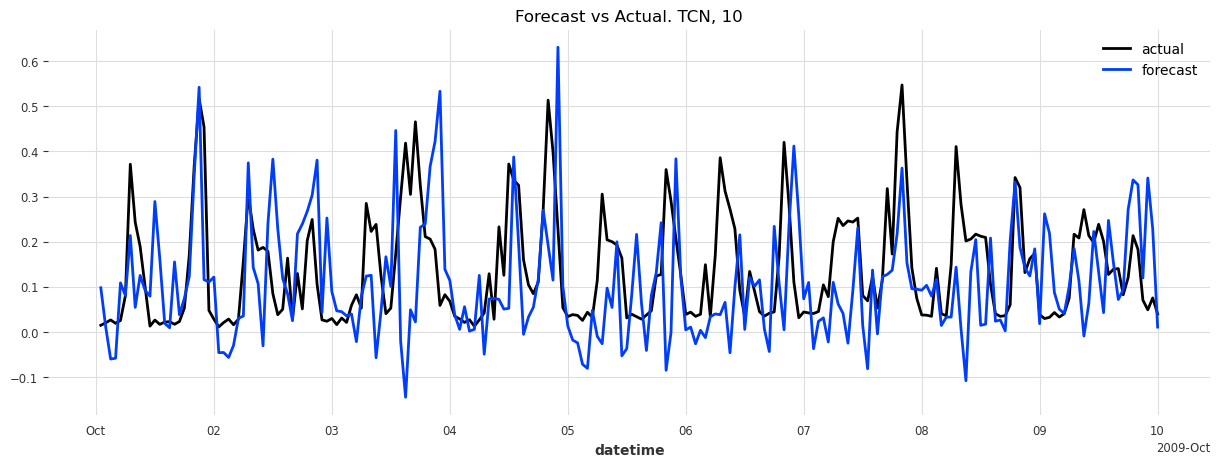

TCN MAPE: 138.25


In [96]:
score_tcn = train_and_evaluate(model_tcn, "TCN", epocas=10)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 711    | train
-------------------------------------------------------------
711       Trainable params
0         Non-trainable params
711       Total params
0.003     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

C:\ProgramData\anaconda3\envs\cuda\Lib\site-packages\pytorch_lightning\core\module.py:512: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 1: Train MAPE = 4.1626
Epoch 2: Train MAPE = 4.1856
Epoch 3: Train MAPE = 4.0805
Epoch 4: Train MAPE = 4.0463
Epoch 5: Train MAPE = 3.9522
Epoch 6: Train MAPE = 4.1137
Epoch 7: Train MAPE = 4.5676
Epoch 8: Train MAPE = 4.0940


`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: Train MAPE = 3.9766


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

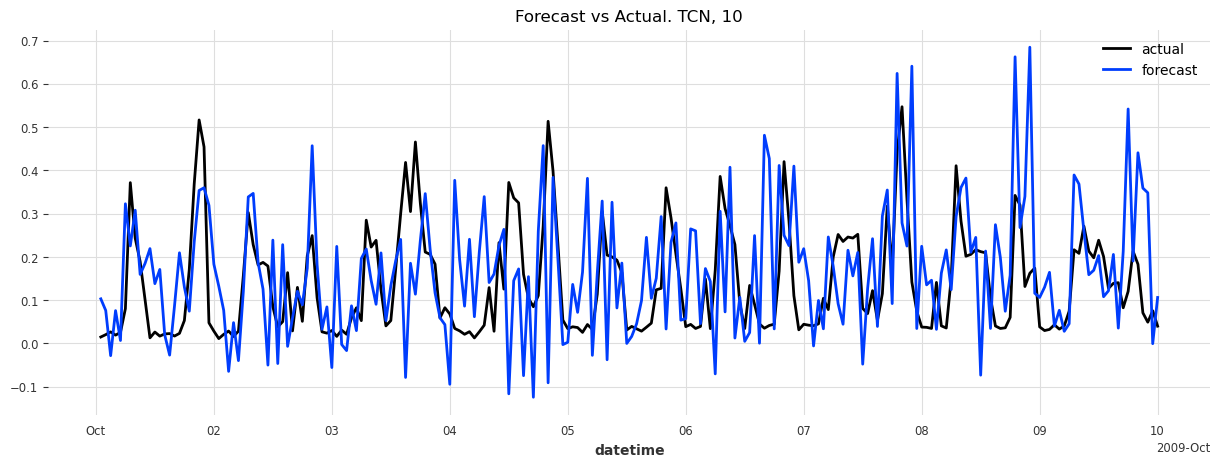

TCN MAPE: 158.10


In [97]:
model_lstm = RNNModel(
    model="LSTM",
    input_chunk_length=48,
    output_chunk_length=24,
    hidden_dim=25,
    n_rnn_layers=2,
    dropout=0.1,
    batch_size=32,
    n_epochs=50,
    random_state=42,
    likelihood=GaussianLikelihood(),
    training_length=48,
)

score_lstm = train_and_evaluate(model_lstm, "TCN", epocas=10)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 711    | train
-------------------------------------------------------------
711       Trainable params
0         Non-trainable params
711       Total params
0.003     Total estimated model params size (MB)
52        Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

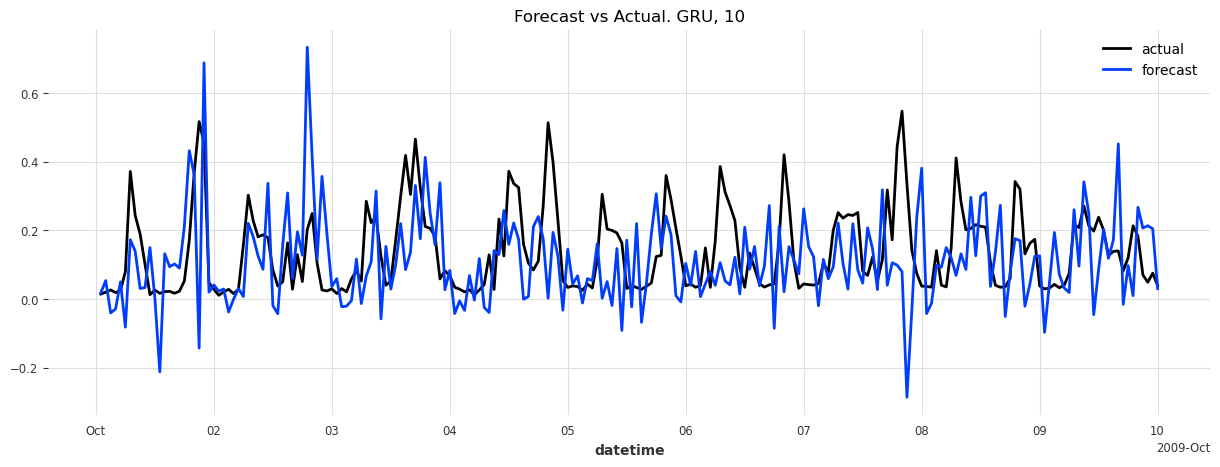

TCN MAPE: 163.59


In [54]:
model_gru = RNNModel(
    model="GRU",
    input_chunk_length=48,
    output_chunk_length=24,
    hidden_dim=25,
    n_rnn_layers=2,
    dropout=0.1,
    batch_size=32,
    n_epochs=50,
    random_state=42,
    likelihood=GaussianLikelihood(),
    training_length=48,
)

score_gru = train_and_evaluate(model_gru, "GRU", epocas=10)

In [55]:
print("\n--- Model Comparison (MAPE) ---")
print(f"TCN: {score_tcn:.2f}%")
print(f"LSTM: {score_lstm:.2f}%")
print(f"GRU: {score_gru:.2f}%")


--- Model Comparison (MAPE) ---
TCN: 178.05%
LSTM: 193.25%
GRU: 163.59%


# 4. Granularidad diaria.


Resulta que no se necesita tener tanto nivel de detalle en el pronóstico, con una predicción diaría sería suficiente.
Además, nos dicen que cada mes se va a renovar el ejercicio, por lo que bastaría con un pronóstico de los siguientes 30 días.

<font color='Red'>Qué es mejor?</font>:
- <font color='Red'>hacer pronóstico horario y agregarlo.</font>
- <font color='Red'>agregar los datos diariamente y crear el pronostico.</font>
- <font color='Red'>comparar con los modelos ingenuos.</font>
